In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary

import numpy as np
from scipy.fft import fft, ifft

import matplotlib.pyplot as plt

import os


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name() if torch.cuda.is_available() else 'cpu')

NVIDIA GeForce RTX 3050 6GB Laptop GPU


# Simulation Config


In [2]:
# Spatial Domain
xmin, xmax = 0, 2*np.pi  # Domain limits
Nx = 512                        # Number of Spatial points
L = abs(xmax - xmin)            # Domain Length
dx = L / (Nx - 1)               # Cell width

_x = np.linspace(xmin, xmax, Nx)
_x_tensor = torch.tensor(_x, dtype=torch.float32, requires_grad=True).view(-1, 1).to(device)


# Temporal Domain
Tf = 2.0                # Final time
dt = 0.01               # Time step
Nt = int(Tf / dt) + 1   # Number of temporal points

_t = np.linspace(0, Tf, Nt)
_t_tensor = torch.tensor(_t, dtype=torch.float32, requires_grad=True).view(-1, 1).to(device)

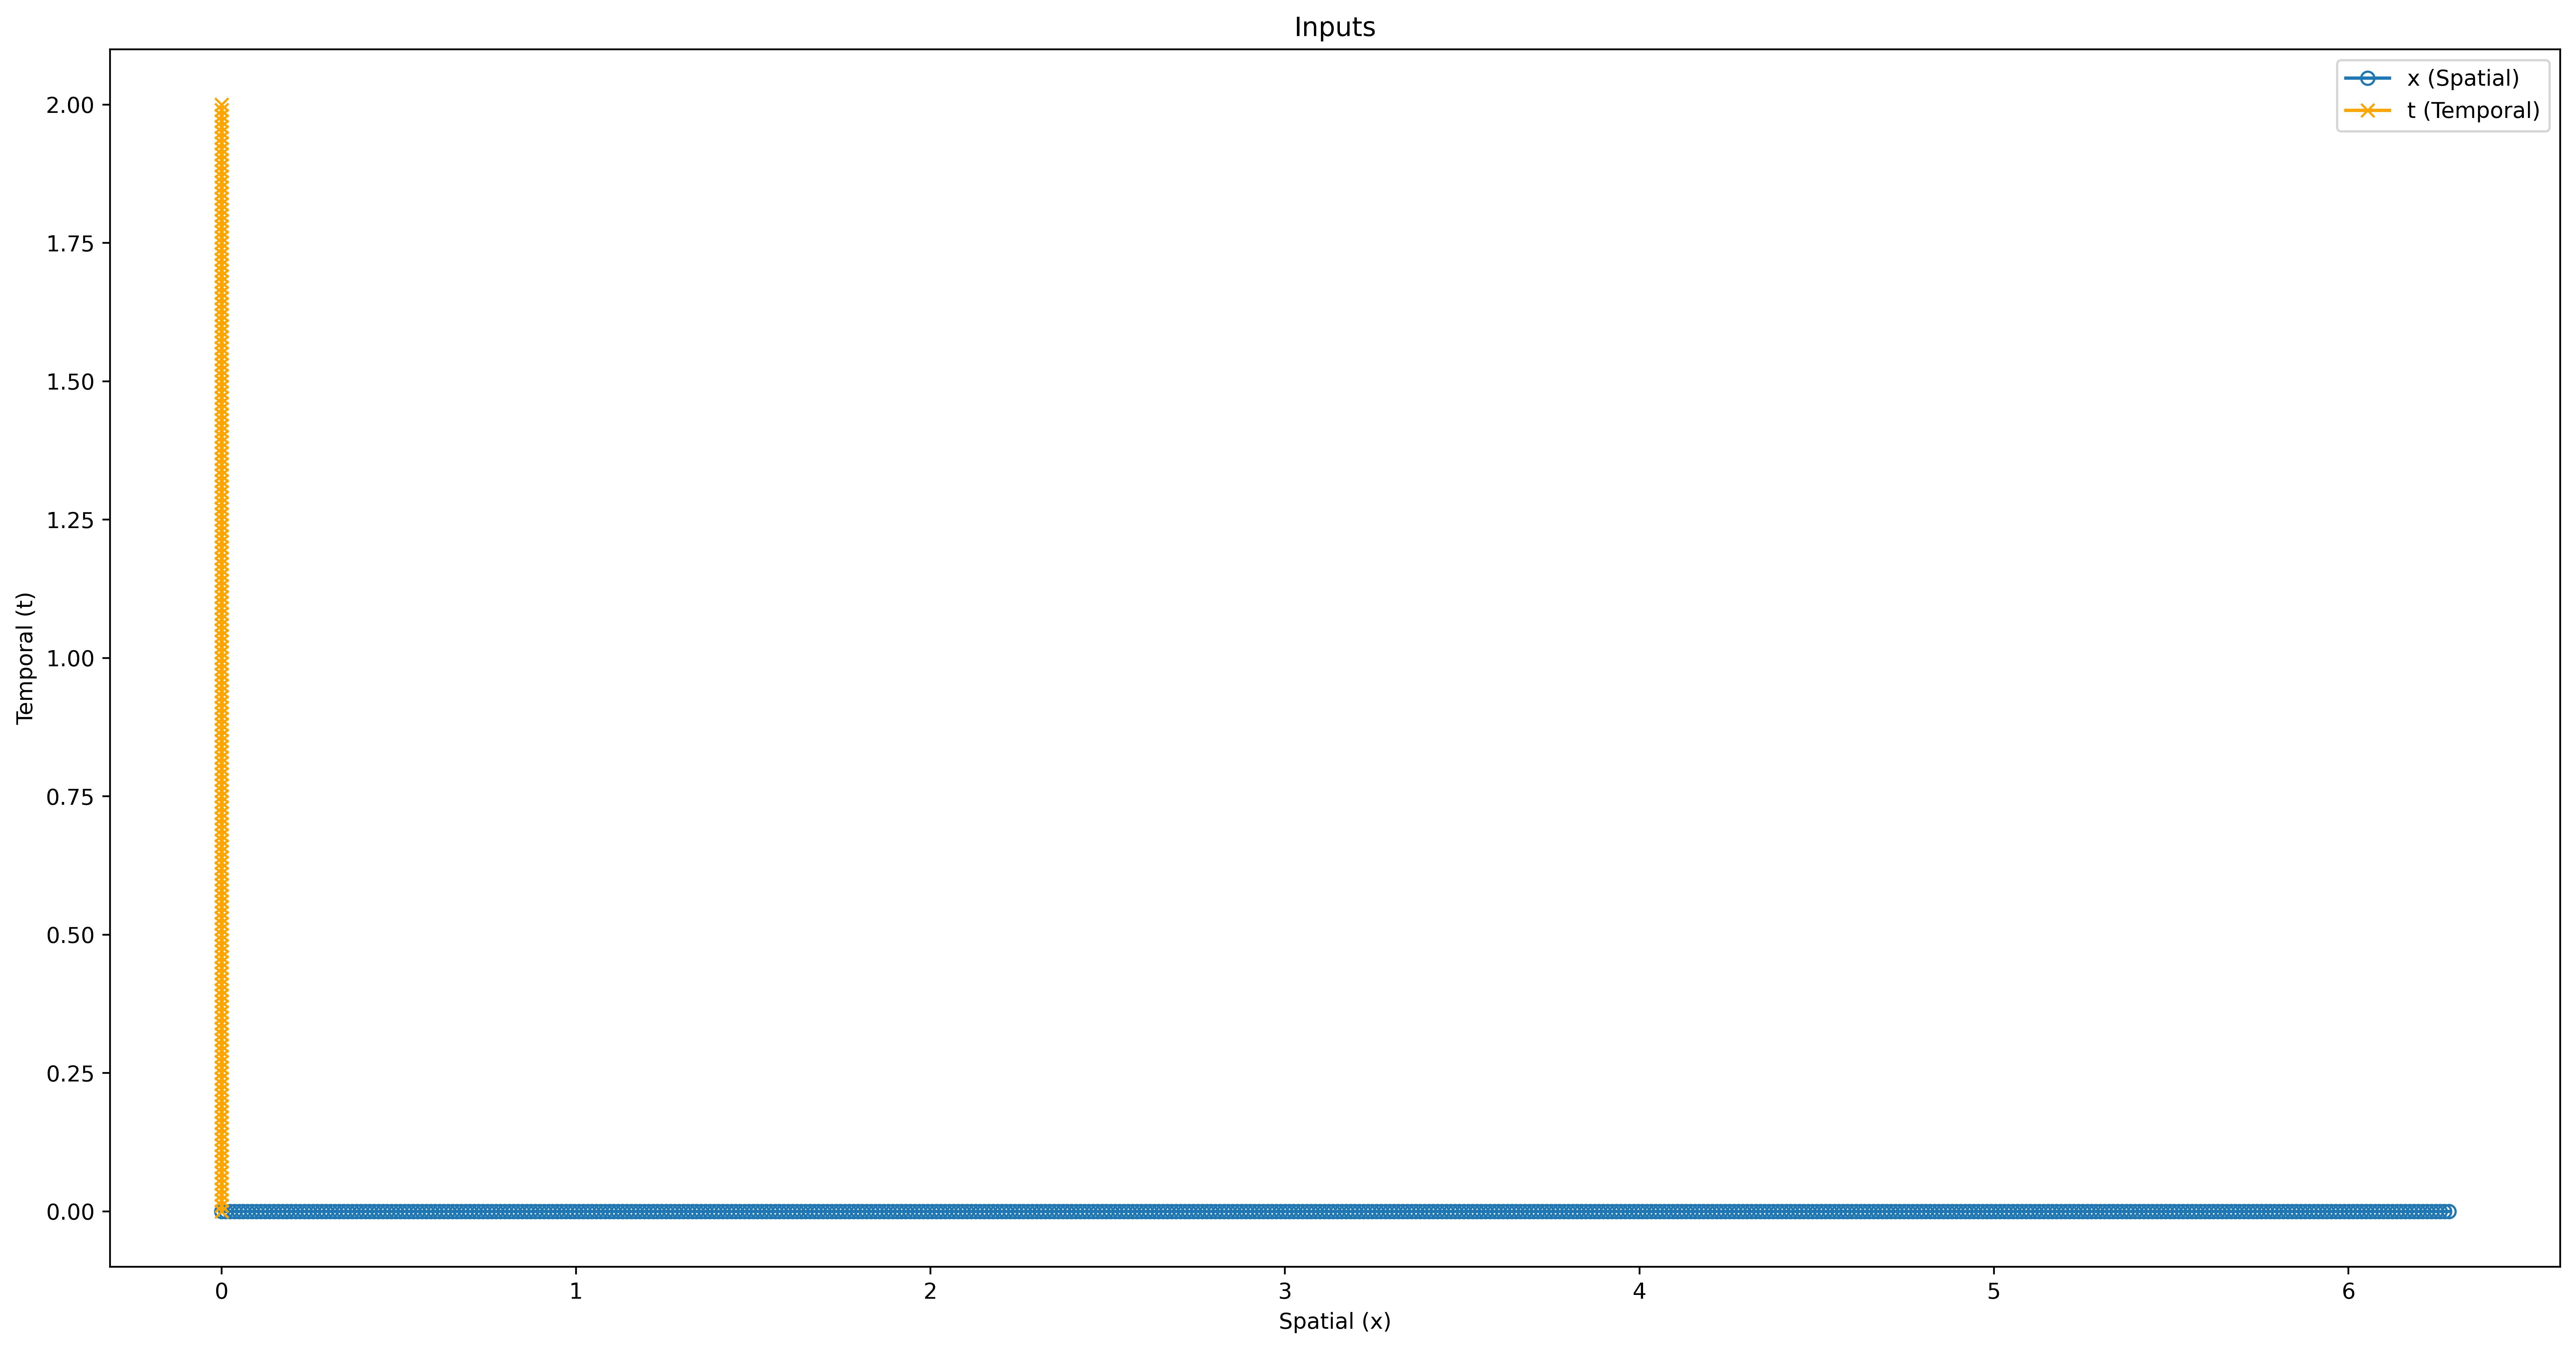

In [3]:
x_np = _x_tensor.detach().cpu().numpy()
t_np = _t_tensor.detach().cpu().numpy()

plt.figure(figsize=(20, 10), dpi=500)
plt.plot(x_np, np.zeros_like(x_np), label='x (Spatial)', marker='o', markerfacecolor='none')
plt.plot(np.zeros_like(t_np), t_np, label='t (Temporal)', marker='x', color='orange')
plt.legend()
plt.title('Inputs')
plt.xlabel('Spatial (x)')
plt.ylabel('Temporal (t)')
plt.show()

## Normalize data

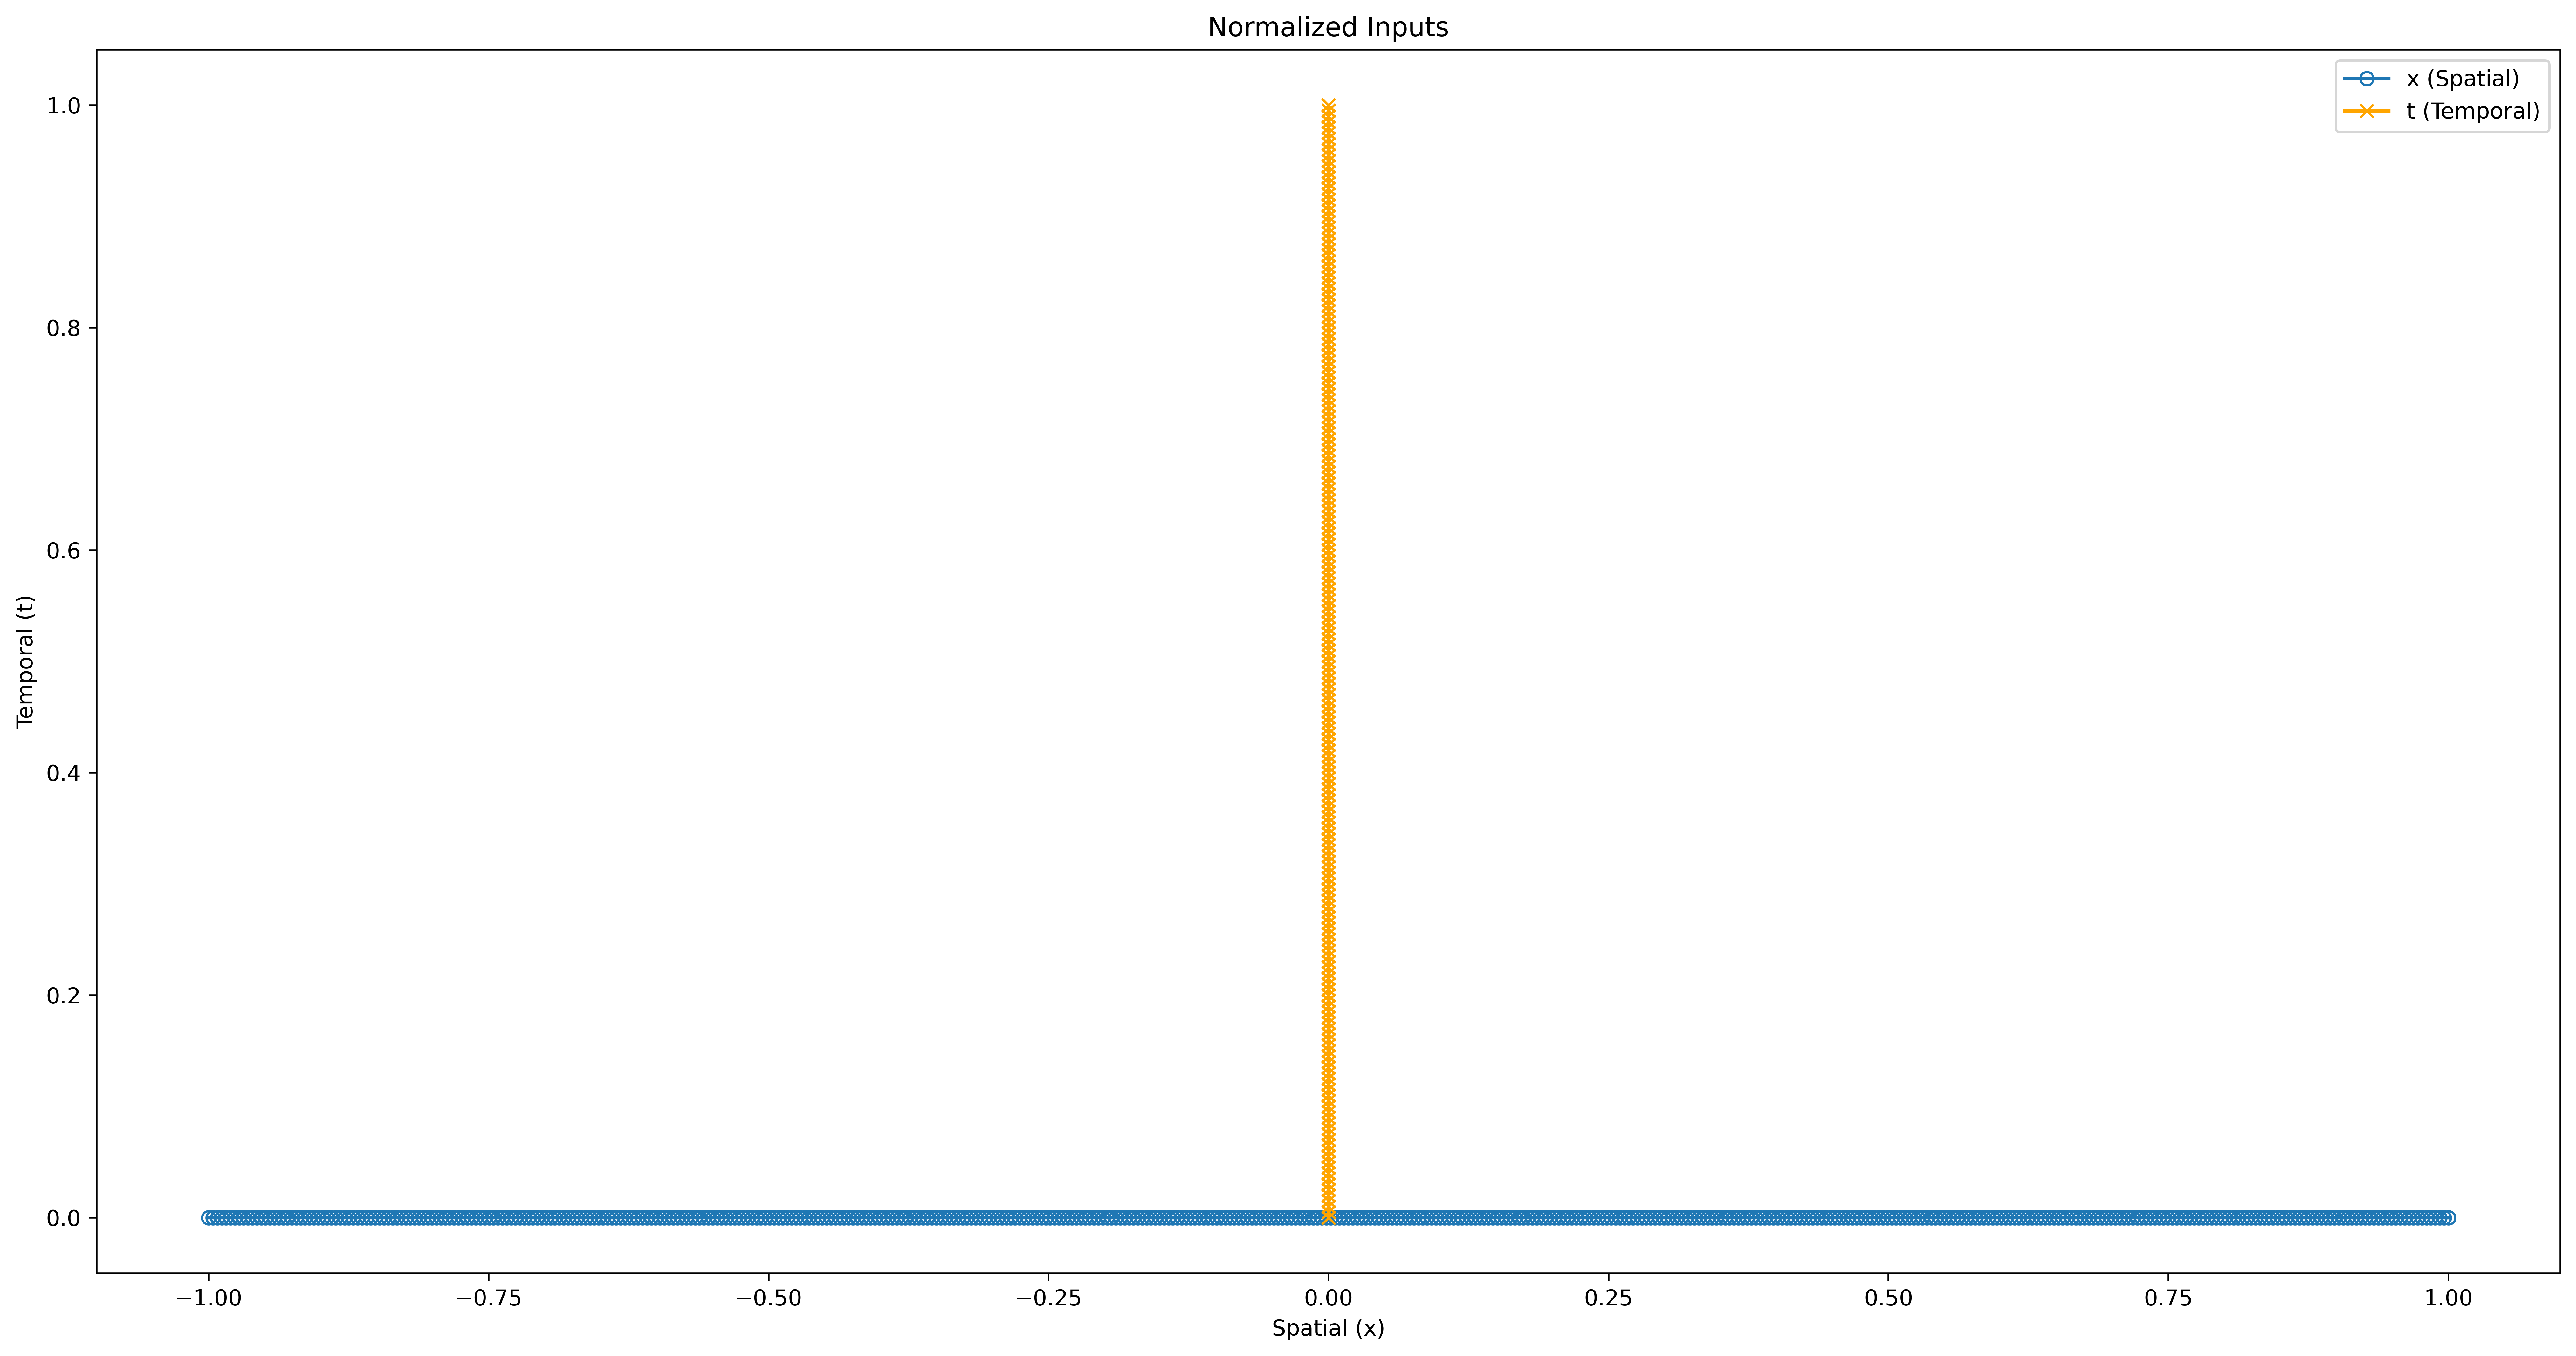

In [4]:
def norm(_tensor):
    """
        Returns normalised data in range [-1, 1].

        Args:- 
        - _tensor: Array to be normalized
    """
    return 2*(_tensor - _tensor.min()) / (_tensor.max() - _tensor.min()) - 1

def norm0(_tensor):
    """
        Returns normalised data in range [0, 1].

        Args:- 
        - _tensor: Array to be normalized
    """
    return (_tensor - _tensor.min()) / (_tensor.max() - _tensor.min())

def denorm(_tensor_norm, _min, _max):
    """
        Returns denormalised data.
        
        Args:- 
        - _tensor_norm: Normalised array
        - _min: Original minimum value
        - _max: Original maximum value
    """
    return (_tensor_norm + 1)/2 * (_max - _min) + _min


x_norm = norm(_x_tensor)
t_norm = norm0(_t_tensor)

plt.figure(figsize=(20, 10), dpi=500)
plt.plot(x_norm.detach().cpu().numpy(), np.zeros_like(x_norm.detach().cpu().numpy()), label='x (Spatial)', marker='o', markerfacecolor='none')
plt.plot(np.zeros_like(t_norm.detach().cpu().numpy()), t_norm.detach().cpu().numpy(), label='t (Temporal)', marker='x', color='orange')
plt.legend()
plt.title('Normalized Inputs')
plt.xlabel('Spatial (x)')
plt.ylabel('Temporal (t)')
plt.show()

# PDE Setup

In [5]:
def initialise(x_tensor, condition):
    """
    Initialize the solution based on different initial conditions.
    
    Args:-
    - x_tensor: Tensor of Nx spatial points.
    - condition: Integer representing the type of initial condition to use.
    
    Returns:
    - u_0: Initial condition evaluated at the spatial points x.
    """
    if condition == 1:
        # Singular initial data
        print("Initial Condition: 1/4 * ((x_j >= 3*pi/4) && (x_j <= 5*pi/4)) + 1/2 * ((x_j >= pi/2) && (x_j <= 3*pi/2)")
        u_0 = 0.25 * ((x_tensor >= 3*np.pi/4) & (x_tensor <= 5*np.pi/4)) + \
              0.5 * ((x_tensor >= np.pi/2) & (x_tensor <= 3*np.pi/2))
    elif condition == 2:
        # Polynomial initial data
        print("Initial Condition: (6/pi^3) * (3*pi/2 - x) * (x - pi/2), if pi/2 <= x < 3*pi/2; 0 otherwise.")

        u_0 = torch.where((x_tensor >= np.pi/2) & (x_tensor < 3*np.pi/2),
                          (6/np.pi**3) * (3*np.pi/2 - x_tensor) * (x_tensor - np.pi/2),
                          torch.zeros_like(x_tensor))
    elif condition == 3:
        # Sine initial data
        print("Initial Condition: sin(x)")
        u_0 = -torch.sin(x_tensor)

    return u_0


# def flux(V_U, u, x_index):
#     return -K*V_U[x_index] * u[x_index]

def flux(u):
    return torch.real(torch.fft.ifft(torch.fft.fft(torch.sin(x_norm)) * torch.fft.fft(u))) * (x_norm.max() - x_norm.min())/(len(x_norm) - 1) * u


# Initial data
u_0_denorm = initialise(_x_tensor, 2).to(device)
u_0 = norm(u_0_denorm)

Initial Condition: (6/pi^3) * (3*pi/2 - x) * (x - pi/2), if pi/2 <= x < 3*pi/2; 0 otherwise.


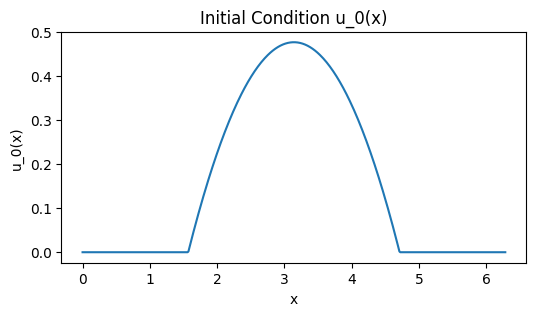

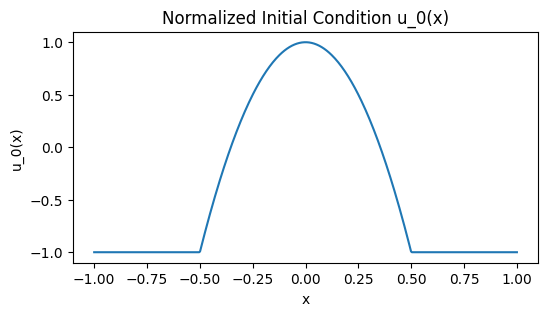

In [6]:
plt.figure(figsize=(6, 3))
plt.plot(_x, u_0_denorm.detach().cpu().numpy(), label='Initial Condition')
plt.title('Initial Condition u_0(x)')
plt.xlabel('x')
plt.ylabel('u_0(x)')
plt.show()

plt.figure(figsize=(6, 3))
plt.plot(x_norm.detach().cpu().numpy(), u_0.detach().cpu().numpy(), label='Initial Condition')
plt.title('Normalized Initial Condition u_0(x)')
plt.xlabel('x')
plt.ylabel('u_0(x)')
plt.show()

# Helper

In [7]:
def plot():
    """
    Plot the sim_data from the PINN model and the exact solution.
    
    Args:-
    - sim_data: Predicted values for each time step (2D array: time x space).
    - ex_data: Optional exact solution data (same shape as sim_data) | Taken from extremely fine mesh using FVM
    """
    sim_data = np.loadtxt('simulation_data.txt')
    
    ex_data_exists = os.path.getsize("u_ex.txt") > 0
    if ex_data_exists:
        ex_data = np.loadtxt('u_ex.txt')

    x = np.linspace(xmin, xmax, Nx)
    
    time_steps = len(sim_data)
    Dt = Tf / (time_steps-1)
    
    plt.xlabel(r'$\theta$')
    plt.ylabel(r'$\mu(\theta)$')

    for _, t in enumerate([0, 16, 32, 64, 128, 200]):
        plt.clf()
        plt.title(f'PINN Simulation after Time Step {t}, t={round(t*Dt, 3)}')

        # Exact Solution
        if ex_data_exists and t == time_steps-1:
            plt.plot(x, ex_data[-1, :], linestyle=":", marker="o", markersize=1, markerfacecolor='none', label='Exact Solution')
        # PINN Solution
        plt.plot(x, sim_data[t, :], linestyle=":", marker="x", markersize=3, label='PINN Prediction')
        
        plt.savefig(f'steps/{t}.png', bbox_inches='tight')
        plt.legend()
        plt.draw()
        plt.pause(0.08)

    # plt.show()


def write_data(file, u):
    """
    Write the simulation results to a file.
    
    Args:-
    - filename: The file object to write to.
    - u: The array of predicted values (1D array for a single time step).
    """
    file.write(" ".join(map(str, u)) + "\n")


def get_param():
    """
    Print the simulation parameters relevant to the PINN model.
    """
    print("\nPINN Simulation Parameters\n")
    print(f"Domain Limits (xmin, xmax): {xmin} , {xmax}")
    print(f"Domain Length (L): {L}")
    print(f"Number of Spatial Points (Nx): {Nx}")
    print(f"Cell Width (dx): {dx}\n")
    print(f"Final Time (Tf): {Tf}\n")
    print(f"Time Step (dt): {dt}")
    print(f"Number of Time Steps (Nt): {Nt}\n")


# Network Architecture
### Simple FeedForward Neural Network

-> 1 input layer

-> 4 fully connected hidden layers; 64 neurons each

-> 1 output layer

In [8]:
class PINN(nn.Module):
    def __init__(self, layers, units):
        """
        Initialise the PINN model.
        
        Args:-
        - layers: number of hidden layers
        - units: number of neurons in each hidden layer 
        """
        super(PINN, self).__init__()
        
        self.layers = nn.ModuleList()
        
        self.layers.append(self.init_siren(nn.Linear(2, units), is_first=True)) # input layer ~> {x, t}
        for _ in range(layers): 
            self.layers.append(self.init_siren(nn.Linear(units, units)))   # hidden layers
        self.layers.append(nn.Linear(units, 1)) # output layer ~> u(x, t)


    def init_siren(self, layer, is_first=False, omega_0=30):
        """
        SInosuidal REpresentation Network-style initialization.
        """
        with torch.no_grad():
            if is_first: 
                nn.init.uniform_(layer.weight, -1/layer.in_features, 1/layer.in_features)
            else: # Scaled Glorot
                nn.init.uniform_(layer.weight, -np.sqrt(6/layer.in_features)/omega_0, np.sqrt(6/layer.in_features)/omega_0)
            
            nn.init.zeros_(layer.bias)
            
            return layer

        
    def forward(self, x_tensor, time_step):
        """
        Forward pass through the network. It takes in time `t` and space `x` and outputs the solution `u(x, t)`.
        
        Args:-
        -  x_tensor: Tensor of N space values 
        - time_step: Time step.
        
        Returns:
        - u: Neural network output representing the function `u(x, t)`.
        """
        t = t_norm[time_step]
        x = x_norm
        
        input_data = torch.cat([x, t.repeat(x.shape[0], 1)], dim=1)
        for layer in self.layers[:-1]:
            input_data = torch.sinc(layer(input_data))      # sinc activation
        output = self.layers[-1](input_data)
        
        return output


    def pde_residual(self, x_tensor, time_step):
        """
        Compute the residual of the PDE: u_t + f(u)_x = 0
        f(u) = -k*V(u_x)*u_x
        
        Args:-
        - x_tensor: Tensor of N space values.
        - time_step: Time step index.
        
        Returns:
        - residual: The residual of the PDE at the given points (t, x).
        """
        u = self.forward(x_tensor, time_step)
        
        ones = torch.ones_like(u)
        u_t = torch.autograd.grad(u, t_norm, grad_outputs=ones, create_graph=True)[0][time_step]
        # u_x = torch.autograd.grad(u, x_norm, grad_outputs=ones, create_graph=True)[0]
        uu_x = torch.autograd.grad(flux(u), x_norm, grad_outputs=ones, create_graph=True)[0]

        # residual = u_t + (-k*V(u)*u)_x

        return u_t + uu_x


    def loss(self, t_tensor, x_tensor, u_0):
        """
        Compute the total loss function including PDE residuals, initial, and boundary conditions.
        
        Args:-
        - t_tensor: Tensor of Nt temporal values.
        - x_tensor: Tensor of N space values.
        - u_0: Tensor of initial condition values for u(x, t0).
        
        Returns:
        - total_loss: The total loss combining PDE residuals, initial condition loss, and boundary loss.
        """
        res = bc = ic = 0
        for time_step in range(len(t_tensor)):
            # PDE residual loss
            res += torch.mean(torch.square(self.pde_residual(x_tensor, time_step)))

            # # Boundary condition loss
            u_pred = self.forward(x_tensor, time_step)
            bc += torch.mean(torch.square(u_pred[0] - u_pred[-1]))  # reduce to scalar
            
        # Initial condition loss
        u_0_pred = self.forward(x_tensor, 0)
        ic += torch.mean(torch.square(u_0_pred - u_0))

        total_loss = (1*res + 0.5*bc)/Nt  + 0.75*ic

        return total_loss, res/Nt, bc/Nt, ic


    def trainer(self, t_tensor, x_tensor, u_0, epochs=2048, lr=1e-4):
        """
        Train the PINN using the provided data and physics constraints.
        
        Args:-
        - t_tensor: Tensor of Nt temporal values.
        - x_tensor: Tensor of N space values.
        - u_0: Tensor of initial condition values for u(x, t0).
        - epochs: Number of training epochs.
        - lr: Learning rate for the optimizer.
        """
        # Adam optimizer
        optimizer = optim.Adam(self.parameters(), lr=lr)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=16)

        # Early stopping
        best_loss = float('inf')
        epochs_no_improve = 0
        patience = 32
        
        loss_list = []
        for epoch in range(epochs):
            optimizer.zero_grad()
            
            loss, res, bc, ic = self.loss(t_tensor, x_tensor, u_0)
            loss_list.append(loss.item())

            loss.backward(retain_graph=True)
            torch.nn.utils.clip_grad_norm_(self.parameters(), max_norm=1.0)

            optimizer.step()
            scheduler.step(loss)


            if loss.item() < best_loss:
                best_loss = loss.item()
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1

            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch}.")
                print(f'Epoch {epoch}/{epochs}, Loss: {loss.item()}, Res: {res}, BC: {bc}, IC: {ic}, LR: {scheduler.get_last_lr()[0]}')
                break
            

            if epoch % 32 == 0:
                print(f'Epoch {epoch}/{epochs}, Loss: {loss.item()}, Res: {res}, BC: {bc}, IC: {ic}, LR: {scheduler.get_last_lr()[0]}')
        
        print("Training complete.")
        plt.semilogy(range(len(loss_list)), loss_list)
        plt.ylabel("Loss")
        plt.xlabel("Epoch")
        plt.title("Training Loss over Epochs")

model = PINN(layers=4, units=64).to(device)

# Training


In [9]:
model.trainer(_t_tensor, _x_tensor, u_0)
summary(model)

C:\Users\89\AppData\Roaming\Python\Python312\site-packages\torch\autograd\graph.py:769: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 0/2048, Loss: 3.1516668796539307, Res: 6.54823161312379e-05, BC: 0.0, IC: 4.20213508605957, LR: 0.0001


# Prediction

In [ ]:
get_param()

out_file = open("simulation_data.txt", 'w')

model.eval()
for time_step in range(len(t_norm)):
    with torch.no_grad():
        u_n = model(x_norm, time_step)
    write_data(out_file, u_n.detach().cpu().numpy().flatten())

out_file.close()

plot()

In [ ]:
! python -u "steps/gif.py"